## VAE Hawkes Process Estimation - Tutorial

In [308]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors
from hawkes.simulation import hawkes_simulations, hawkes_simulation
from hawkes.discretisation import discretise
from visualization.model_effect import convergence_rate, error_boxplots
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import write_parquet, read_parquet, timer
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Preprocessing

In [2]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, mu = hyper_params_simulation(filename="hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename='hawkes_simulations.parquet')

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename='binned_hawkes_simulations.parquet')

In [255]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data)

x = read_parquet("binned_hawkes_simulations.parquet")
y = read_parquet('hawkes_hyperparams.parquet')

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[[y.columns[0], y.columns[2]]]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [256]:
# Trained model

model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MLP                                      [10000, 100]              [10000, 2]                --                             --                   --                        --                        True
├─Linear: 1-1                            [10000, 100]              [10000, 100]              10,100                     14.25%                   --                        101,000,000               True
├─ModuleList: 1-2                        --                        --                        --                             --                   --                        --                        True
│    └─Sequential: 2-1                   [10000, 100]              [10000, 100]              --                             --                   --                        --              

Epoch 238/238 - train_loss: 0.0986, val_loss: 0.1158: 100%|██████████| 238/238 [30:57<00:00,  7.81s/it]


Best model loading (2023_05_06_02_47_25_MICSHPEG8GIRARD_best_model.pt)...
Validation set - Estimated branching ratio (η): 0.4154, Estimated baseline intensity (µ): 2.9187


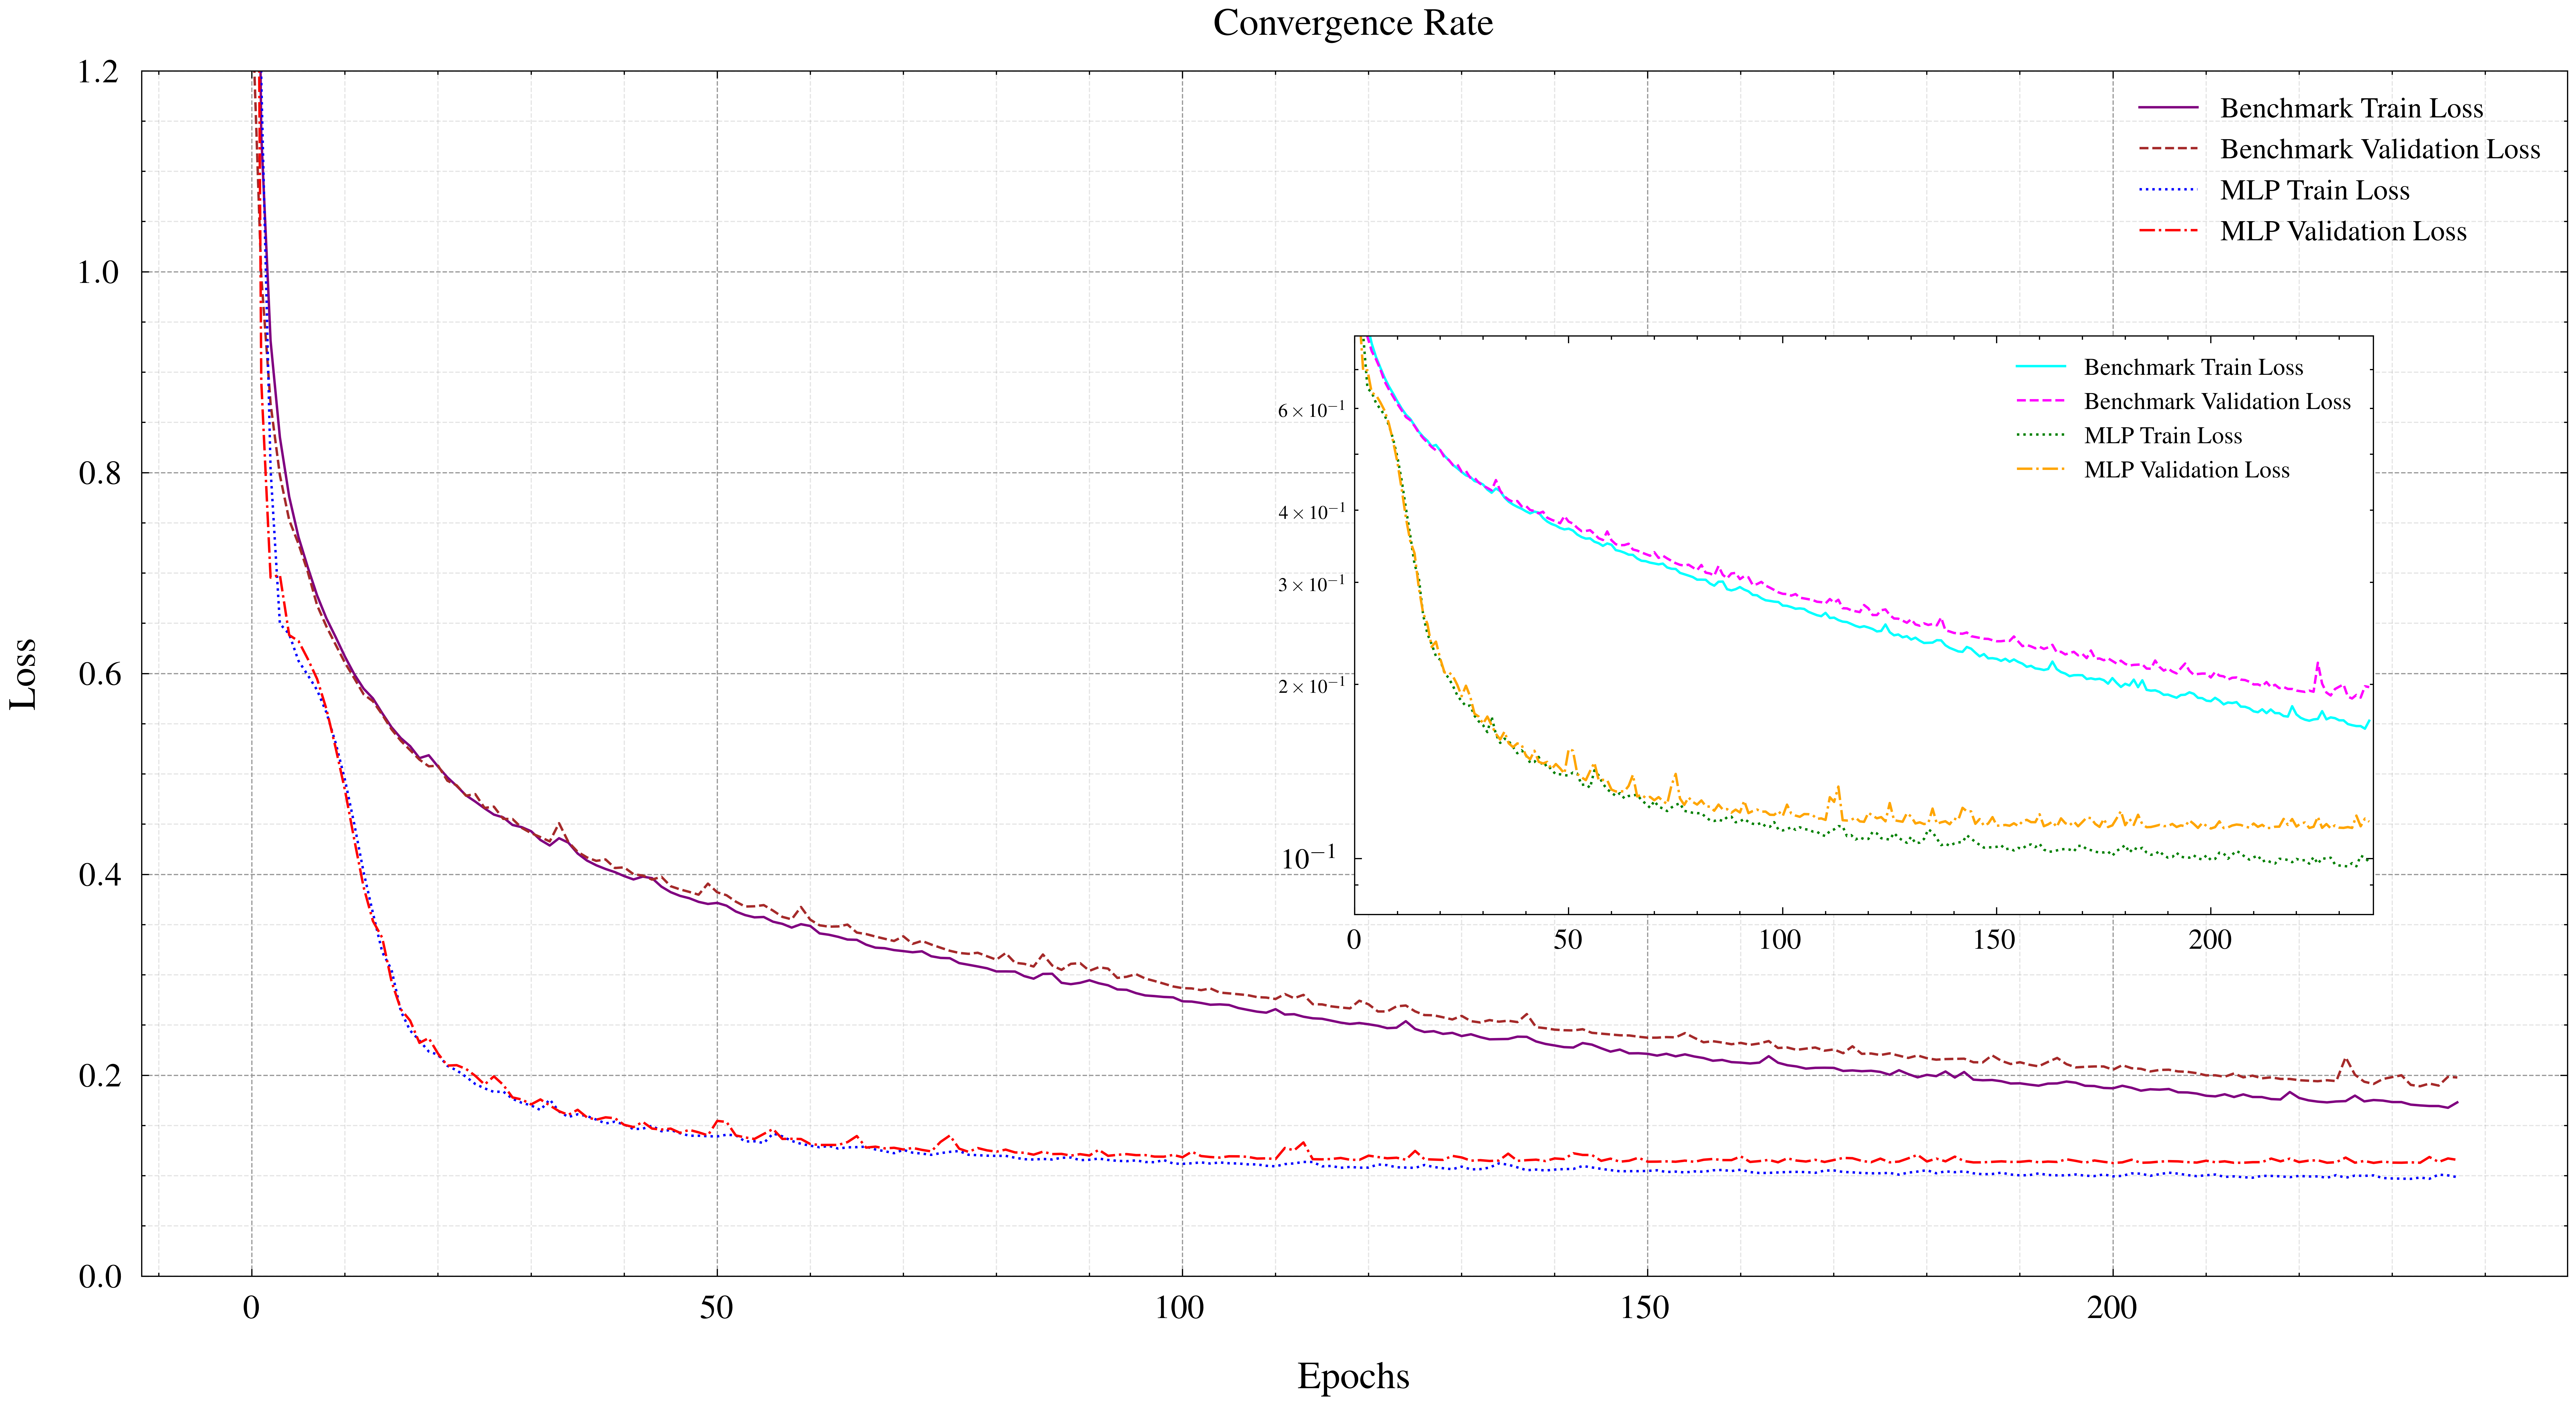

In [23]:
# Convergence rate plots

bench_losses = read_parquet('losses_benchmark.parquet')
mlp_losses = read_parquet('losses_mlp.parquet')

convergence_rate(bench_losses, mlp_losses)

In [24]:
# Tested model (if pandas: y = y.iloc[:, [0, 2]] in split_data)

x = read_parquet("binned_hawkes_simulations_test.parquet")
y = read_parquet('hawkes_hyperparams_test.parquet')

test_x, test_y, empty_train_x, empty_train_y, empty_val_x, empty_val_y = split_data(x, y[[y.columns[0], y.columns[2]]])
test_dataset, empty_train_dataset, empty_val_dataset = create_datasets(test_x, test_y, empty_train_x, empty_train_y, empty_val_x, empty_val_y)
test_loader, empty_train_loader, empty_val_loader = create_data_loaders(test_dataset, empty_train_dataset, empty_val_dataset)

test_y_pred, test_loss, test_eta, test_mu = MLPTrainer().test_model(test_loader, test_y)
%load_ext tensorboard

Test set - Test loss: 5.1723, Estimated branching ratio (η): 0.0188, Estimated baseline intensity (µ): -0.0083


Benchmark - MAE: 0.7452, MRE: 0.7390
MLP - MAE: 1.8488, MRE: 0.9831


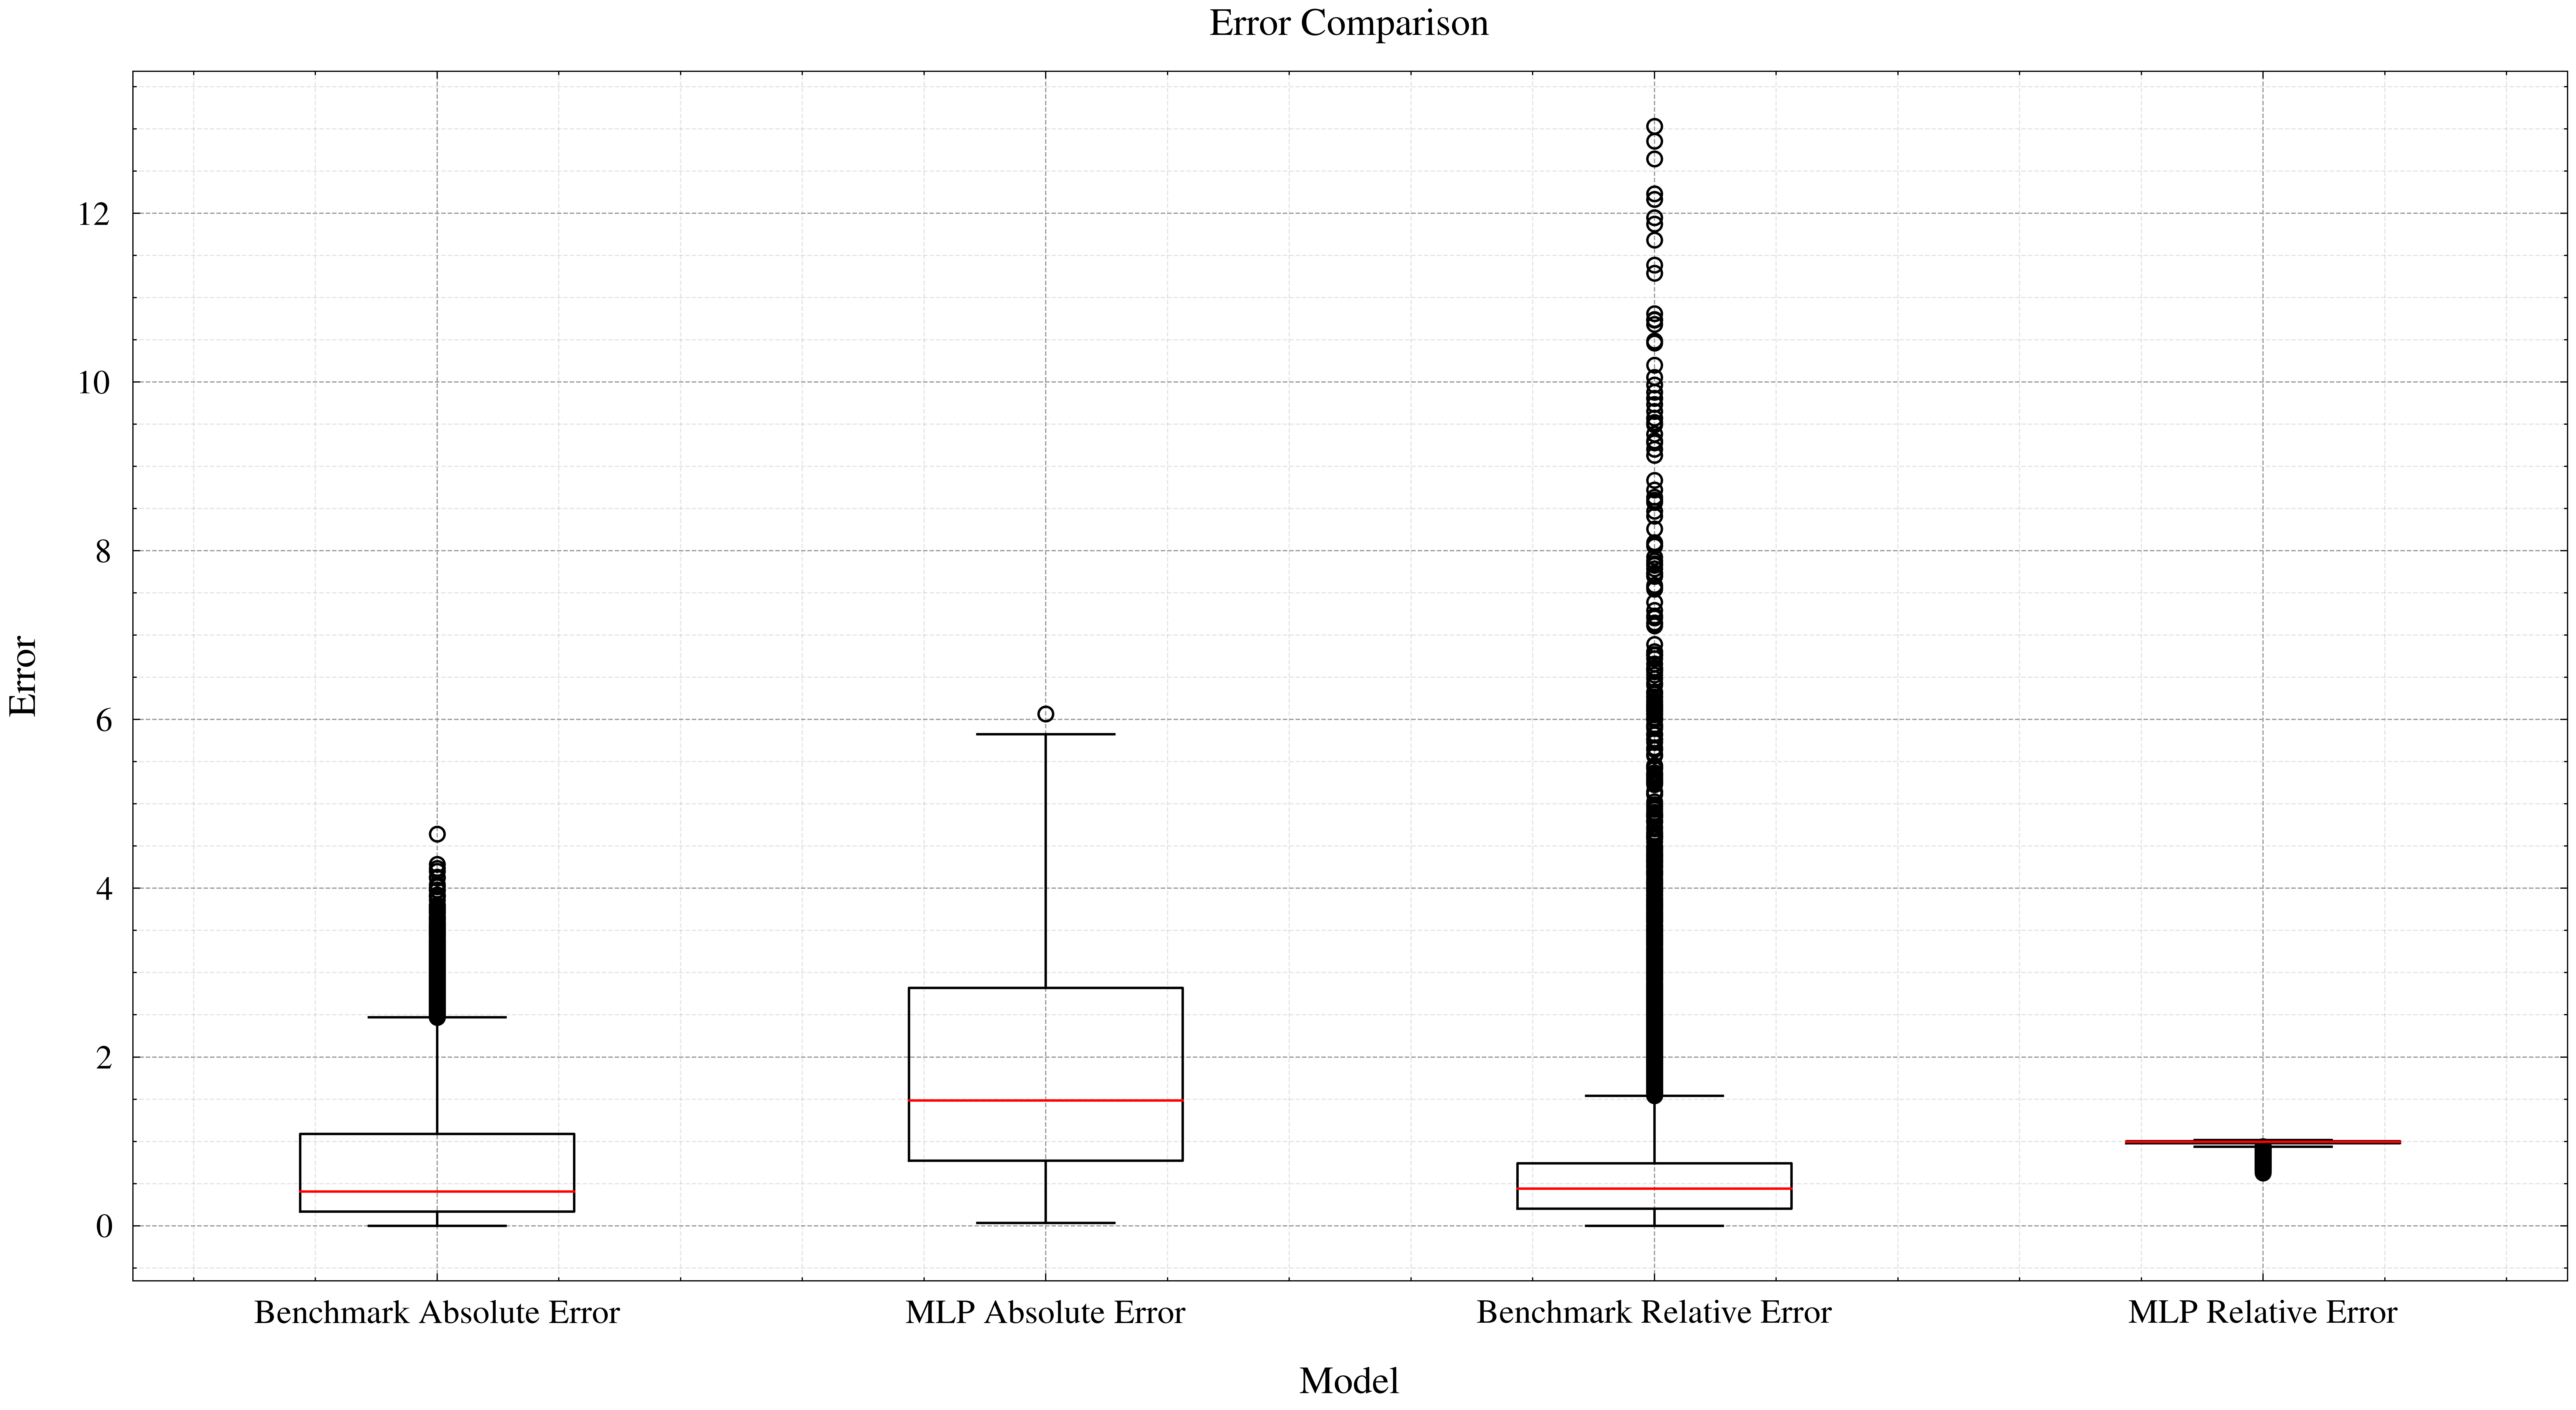

In [36]:
# Computed absolute/relative error + boxplots

bench_pred = read_parquet('predictions_benchmark.parquet')
mlp_pred = read_parquet('predictions_mlp.parquet')

bench_abs_error, bench_rel_error = compute_errors(bench_pred[['eta_true', 'mu_true']], bench_pred[['eta_pred', 'mu_pred']])
mlp_abs_error, mlp_rel_error = compute_errors(mlp_pred[['eta_true', 'mu_true']], mlp_pred[['eta_pred', 'mu_pred']], model_name='MLP')

error_boxplots(bench_abs_error, bench_rel_error, mlp_abs_error, mlp_rel_error)

In [261]:
# Hawkes process hyper-parameters generation
params, alpha, beta, mu = hyper_params_simulation(filename="test1.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename='test2.parquet')

discret_simulated_events_seqs = discretise(simulated_events_seqs, filename='test3.parquet')

Process 1000/1000 - Events: 464: 100%|██████████| 1000/1000 [00:06<00:00, 158.88it/s]


In [ ]:
# Tests and comparison (Testing Effects of Parameters = β, η, ∆, E)

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.2, b = 0.6)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 200
# Number of tests = 100

# Intensity Decay Parameter (β) | Branching Ratio (η) | Interval Length (∆) | Expected Activity (E)
                                                                   
#          [0.5,2.5]                   [0.1,0.4]               0.25                   50
#         [1.75,3.75]                  [0.3,0.6]               0.5                    100
#            [3,5]                     [0.5,0.8]                1                     250
#           [0.5,3]                    [0.1,0.6]                2                     500
#           [1.5,4]                    [0.2,0.7]                5                     1000
#           [2.5,5]                    [0.3,0.8]
#           [0.5,4]                    [0.05,0.6]
#           [1.5,5]                    [0.05,0.7]
#           [0.5,5]                    [0.05,0.8]

# Hawkes process hyper-parameters generation
params, alpha, beta, mu = hyper_params_simulation(filename="hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename='hawkes_simulations.parquet')

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename='binned_hawkes_simulations.parquet')